# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable one.

Replicating the Vision Transformer (ViT) architecture/paper with PyTorch

## 0. Get setup

Let's import code we've written

In [ ]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split('.')[0]) >= 2, 'Upgrade'
  assert int(torchvision.__version__.split('.')[1]) >= 13, 'Upgrade'
except:
  !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu121
  import torch
  import torchvision

In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning.git
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves


Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 39.71 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

The whole goal of what're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.


In [ ]:
image_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip',
              destination='pizza_steak_sushi')

image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Dataset and DataLoader

In [ ]:
from torchvision import transforms

IMG_SIZE = 224
manual_transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()])
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [ ]:
BATCH_SIZE = 8
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               manual_transform,
                                                                               BATCH_SIZE)

In [ ]:
from torchvision import datasets

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=manual_transform)

In [ ]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
one_batch = next(iter(train_dataloader))
len(one_batch), one_batch[1]

(2, tensor([0, 0, 1, 0, 1, 1, 0, 2]))

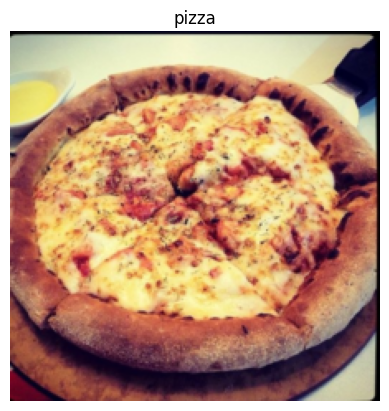

In [ ]:
plt.imshow(one_batch[0][0].permute(1, 2, 0))
plt.title(class_names[one_batch[1][0]])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more understandable, we can break it down into smaller pieces.

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Models** - A collection of blocks.

### 3.1 ViT overview: pieces of the puzzle

* Figures 1: Visual overview of the architecture.
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1"/>

* Embedding = learnable representation (start with random numbers and improve them over time)

### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt='Equations'/>

In pseudo code:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_path_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos]

# Equation 2:
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3:
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

# Equation 4:
y = Linear_layer(LN_layer(x_output_MLP_block_class_token))
```

**Equation 4:**
* MLP: one hidden layer at training time.
* MLP: single linear layer at fine-tuning time.

#### Table 1
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt='Table'/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers.
* Hidden size $D$ - the embedding size throughout the architecture.
* MLP size - the number of hidden units/neurons in the MLP
* Head - the number of multi-head self-attention

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
$H\times W\times C$
* Output shape: $N \times P^2 \cdot C$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (H * W) / P^2
* D = constant latent vector size = embedding dimension.

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16
number_of_patches = int(height * width / patch_size ** 2)
d = 768

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (sequence of 1D vectors): {embedding_layer_output_shape}')

Input shape (single 2D image): (224, 224, 3)
Output shape (sequence of 1D vectors): (196, 768)


### 4.2 Turning a single image into patches

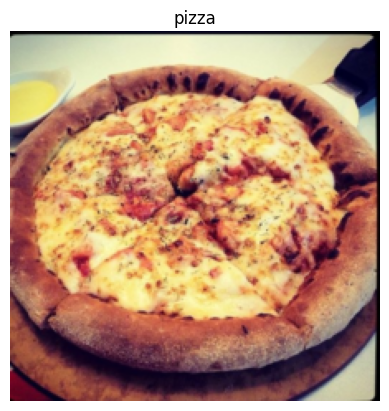

In [ ]:
# View a single image
plt.imshow(one_batch[0][0].permute(1, 2, 0))
plt.title(class_names[one_batch[1][0]])
plt.axis(False);

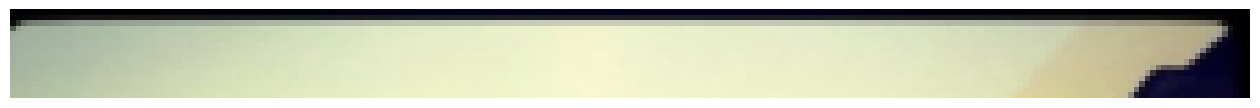

In [ ]:
# Get the top row of the image
image = one_batch[0][0]

image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

In [ ]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'

Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


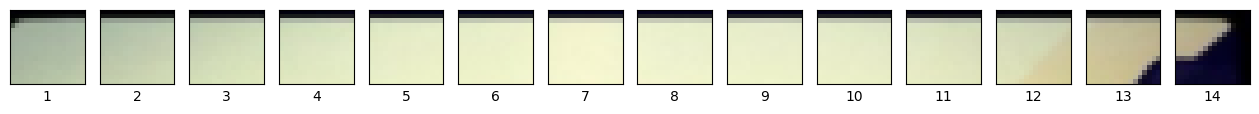

In [ ]:
fig, ax = plt.subplots(nrows = 1,
                       ncols = num_patches,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size))

print(f'Number of patches per row: {num_patches}')
print(f'Patch size: {patch_size} pixels x {patch_size} pixels')

for i, patch in enumerate(range(0, img_size, patch_size)):
  image = image_permuted[:patch_size, patch:patch_size + patch, :]
  ax[i].imshow(image)
  ax[i].set_xlabel(i + 1)
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  #ax[i].axis(False);


Number of patches per row: 14
Number of patches per column: 14
Total patches 196
Patch size: 16 pixels x 16 pixels


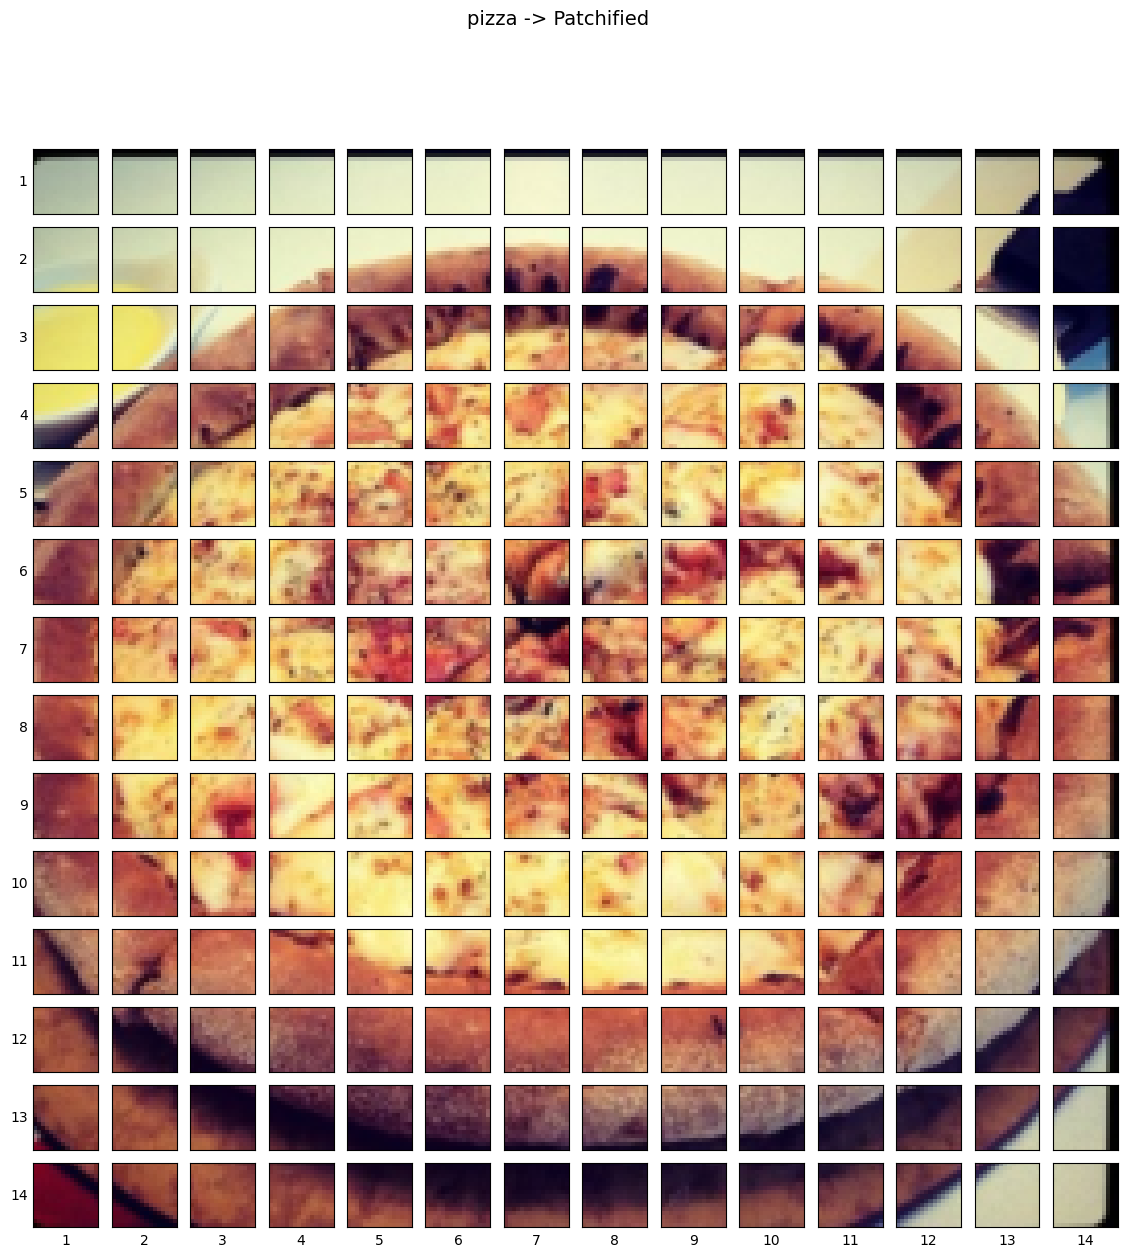

In [ ]:
fig, ax = plt.subplots(nrows=num_patches,
                       ncols=num_patches,
                       sharex=True,
                       sharey=True,
                       figsize=(num_patches, num_patches))

print(f'Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches {num_patches**2}\
\nPatch size: {patch_size} pixels x {patch_size} pixels')

for i, row in enumerate(range(0, img_size, patch_size)):
  for j, col in enumerate(range(0, img_size, patch_size)):
    image = image_permuted[row:row + patch_size, col:patch_size + col, :]
    ax[i, j].imshow(image)
    ax[i, j].set_xlabel(j + 1)
    ax[i, j].set_ylabel(i + 1,
                        rotation='horizontal',
                        horizontalalignment='right',
                        verticalalignment='center')
    ax[i, j].label_outer()
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])

fig.suptitle(f'{class_names[one_batch[1][0]]} -> Patchified', fontsize=14)
plt.show()

### 4.3 Creating image patches and turning them into patch embedding

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`

In [ ]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # D (embedding size) from table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

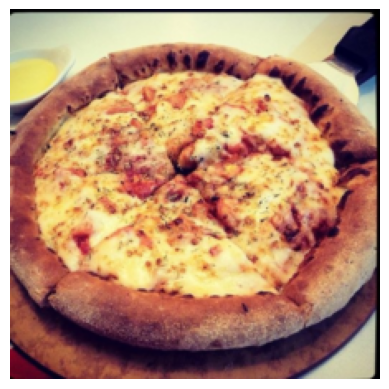

In [ ]:
# View a single image
image = one_batch[0][0]
plt.imshow(image.permute(1, 2, 0))
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, h, w)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [ ]:
flatten = nn.Flatten(start_dim = 2, end_dim=-1)
flatten(image_out_of_conv).shape

torch.Size([1, 768, 196])

In [ ]:
image_out_of_conv.requires_grad, image_out_of_conv.detach().requires_grad, image_out_of_conv.requires_grad

(True, False, True)

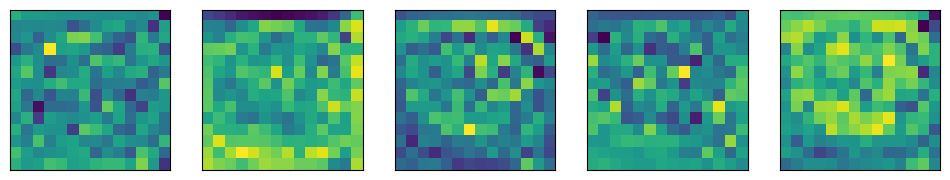

In [ ]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k = 5)

# Create plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random feature map
# detach(): remove from grad tracking
# numpy(): switch to numpy for matplotlib
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axes[i].imshow(image_conv_feature_map.squeeze().detach())
  axes[i].set(xticklabels=[], yticklabels=[], xticks = [], yticks=[])


In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map.requires_grad, single_feature_map.shape, single_feature_map

(True,
 torch.Size([1, 14, 14]),
 tensor([[[-0.3218, -0.3394, -0.3681, -0.3859, -0.3986, -0.4077, -0.4166,
           -0.4147, -0.4050, -0.4035, -0.3852, -0.3889, -0.3678, -0.0088],
          [-0.5482, -0.5399, -0.5868, -0.7008, -0.5725, -0.5619, -0.4755,
           -0.5537, -0.6366, -0.6149, -0.6119, -0.5575, -0.0339, -0.0645],
          [-0.5236, -0.4570, -0.5346, -0.3100, -0.2383, -0.5019, -0.2166,
           -0.2674, -0.3382, -0.4374, -0.1488, -0.5412, -0.3679, -0.1846],
          [-0.2966, -0.4055, -0.3172, -0.4177, -0.5876, -0.4369, -0.4999,
           -0.5112, -0.5289, -0.4249, -0.3194, -0.1301, -0.5601, -0.6164],
          [-0.2833, -0.4080, -0.4788, -0.4704, -0.5102, -0.5007, -0.5533,
           -0.6072, -0.6124, -0.5849, -0.4905, -0.4335, -0.2673, -0.5743],
          [-0.3224, -0.4876, -0.4691, -0.3416, -0.4348, -0.5150, -0.3877,
           -0.4440, -0.3247, -0.4051, -0.4217, -0.4902, -0.0562, -0.2870],
          [-0.2734, -0.4336, -0.4205, -0.4134, -0.3381, -0.4063, -0.0958,

### 4.4 Flatten the patch embedding with torch.nn.Flatten()

In [ ]:
flatten_layer = torch.nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Image shape: torch.Size([3, 224, 224])
Image feature map torch.Size([1, 768, 14, 14])
Image feature map flatten torch.Size([1, 768, 196])


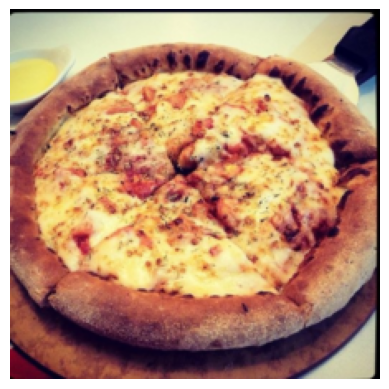

In [ ]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)
print(f'Image shape: {image.shape}')

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Image feature map flatten {image_out_of_conv_flattened.shape}')

torch.Size([1, 196])
tensor([[-0.3218, -0.3394, -0.3681, -0.3859, -0.3986, -0.4077, -0.4166, -0.4147,
         -0.4050, -0.4035, -0.3852, -0.3889, -0.3678, -0.0088, -0.5482, -0.5399,
         -0.5868, -0.7008, -0.5725, -0.5619, -0.4755, -0.5537, -0.6366, -0.6149,
         -0.6119, -0.5575, -0.0339, -0.0645, -0.5236, -0.4570, -0.5346, -0.3100,
         -0.2383, -0.5019, -0.2166, -0.2674, -0.3382, -0.4374, -0.1488, -0.5412,
         -0.3679, -0.1846, -0.2966, -0.4055, -0.3172, -0.4177, -0.5876, -0.4369,
         -0.4999, -0.5112, -0.5289, -0.4249, -0.3194, -0.1301, -0.5601, -0.6164,
         -0.2833, -0.4080, -0.4788, -0.4704, -0.5102, -0.5007, -0.5533, -0.6072,
         -0.6124, -0.5849, -0.4905, -0.4335, -0.2673, -0.5743, -0.3224, -0.4876,
         -0.4691, -0.3416, -0.4348, -0.5150, -0.3877, -0.4440, -0.3247, -0.4051,
         -0.4217, -0.4902, -0.0562, -0.2870, -0.2734, -0.4336, -0.4205, -0.4134,
         -0.3381, -0.4063, -0.0958, -0.4504, -0.4165, -0.4782, -0.5505, -0.6415,
       

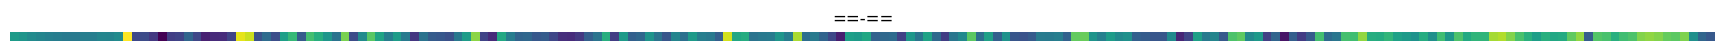

In [ ]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
print(single_flattened_feature_map.shape)
print(single_flattened_feature_map)
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach())
plt.axis(False)
plt.title('==-==');

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int = 3,
               patch_size:int = 16,
               embedding_dim:int = 768):
    super().__init__()
    self.patch_size = patch_size

    # Layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)

    # Flatten embedded patches into vectors
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f'Must be divisible'

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)


In [ ]:
set_seeds()

patchify = PatchEmbedding()

patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[2]

# Create class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones((batch_size, 1, 768)),
                          requires_grad=True,)

class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat([class_token, image_out_of_conv_flattened_permuted], dim=1)
patch_embedded_image_with_class_embedding.shape, patch_embedded_image_with_class_embedding

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3218, -0.6948, -0.7004,  ...,  0.0200, -0.4731, -0.1346],
          [-0.3394, -0.7415, -0.7973,  ...,  0.0479, -0.5224, -0.1371],
          ...,
          [-0.3537, -0.2854, -0.4667,  ...,  0.0494, -0.1883,  0.0589],
          [-0.4729, -0.8087, -0.7507,  ...,  0.0168, -0.5970, -0.2070],
          [-0.5066, -0.9951, -0.9159,  ...,  0.1590, -0.6739, -0.2126]]],
        grad_fn=<CatBackward0>))

In [ ]:
range_image_tensor = torch.rand((1, 3, 224, 224))
range_image_tensor_bad = torch.rand((1, 3, 250, 250))

### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3218, -0.6948, -0.7004,  ...,  0.0200, -0.4731, -0.1346],
          [-0.3394, -0.7415, -0.7973,  ...,  0.0479, -0.5224, -0.1371],
          ...,
          [-0.3537, -0.2854, -0.4667,  ...,  0.0494, -0.1883,  0.0589],
          [-0.4729, -0.8087, -0.7507,  ...,  0.0168, -0.5970, -0.2070],
          [-0.5066, -0.9951, -0.9159,  ...,  0.1590, -0.6739, -0.2126]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones((batch_size, number_of_patches + 1, embedding_dimension)),
                                   requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.6782, 0.3052, 0.2996,  ..., 1.0200, 0.5269, 0.8654],
          [0.6606, 0.2585, 0.2027,  ..., 1.0479, 0.4776, 0.8629],
          ...,
          [0.6463, 0.7146, 0.5333,  ..., 1.0494, 0.8117, 1.0589],
          [0.5271, 0.1913, 0.2493,  ..., 1.0168, 0.4030, 0.7930],
          [0.4934, 0.0049, 0.0841,  ..., 1.1590, 0.3261, 0.7874]]],
        grad_fn=<AddBackward0>))

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings

In [ ]:
# Set seeds
set_seeds()

# 1. Set the batch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimension
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1:]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)

# 6. Create class token
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones((batch_size, 1, 768)),
                           requires_grad=True)

print(f'Class token shape: {class_token.shape}')

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat([class_token, patch_embedding], dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

# 8. Create position embedding
number_of_patches = int((height * width) / (patch_size**2))
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = position_embedding + patch_embedding_class_token
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention**: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch
* **LayerNorm**: smoother gradient, faster training, better generalization accuray.
  * Normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
  * When we normalize along the embedding dimension, it's like making all the stairs in a staircase the same size. (same mean and same standard deviation across the embedding dimension).

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short).
  """

  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0 ):

    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)


  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)

    return attn_output

In [ ]:
# Create an instance of MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock()

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1461, 1.1971, 0.7585,  ..., 1.5138, 0.8825, 1.2216],
         [0.1242, 1.1963, 0.7575,  ..., 1.5118, 0.8529, 1.2223],
         ...,
         [0.6743, 1.1367, 0.5755,  ..., 1.5632, 0.8240, 1.1372],
         [0.0449, 1.3213, 0.7735,  ..., 1.6154, 0.7349, 1.2790],
         [0.6556, 0.9354, 0.7571,  ..., 1.5704, 0.8339, 1.1320]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.2193, -0.2575,  0.0724,  ..., -0.4310,  0.9024, -0.4713],
         [-0.2243, -0.2442,  0.0851,  ..., -0.4296,  0.9248, -0.4850],
         [-0.2243, -0.2439,  0.0842,  ..., -0.4302,  0.9243, -0.4850],
         ...,
         [-0.2258, -0.2454,  0.0846,  ..., -0.4304,  0.9205, -0.4868],
         [-0.2207, -0.2452,  0.0855,  ..., -0.4331,  0.9242, -0.4868],
         [-0.2211, -0.2433,  0.0811,  ..., -0.4352,  0.9199, -0.4836]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):

    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout))

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

### 7.1 Create a custom Transformer Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:int=0):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [ ]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])


Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]             [1, 197, 768]             --                        True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention (multihead_attn)         --                        [1, 197, 768]             2,362,368                 True
├─MLPBlock (mlp_block)                             [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential (mlp)                            [1, 19

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dimension,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

### 8. Putting it all together to create ViT

In [ ]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dimension:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=3):
    super().__init__()

    assert img_size % patch_size == 0, 'Must be divisible'

    # Calculate number of patches
    self.num_patches = img_size**2 // patch_size**2

    # Create learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dimension),
                                        requires_grad=True)
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dimension),
                                           requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dimension)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dimension,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout,
                                                                       attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dimension),
        nn.Linear(in_features=embedding_dimension, out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # Create the patch embedding
    x = self.patch_embedding(x)

    # Concat class token embedding
    x = torch.cat((class_token, x), dim=1)

    # Add position embedding
    position_embedding = self.position_embedding.expand(batch_size, -1, -1)
    x = x + self.position_embedding

    # Apply Dropout to patch embedding ("directly after adding position- to patch embedding")
    x = self.embedding_dropout(x)

    # Pass to Transformer Encoder
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier
    logits = self.classifier(x[:, 0])

    return logits

In [ ]:
vit = ViT()
vit(torch.randn(1, 3, 224, 224))
summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.3 Training our ViT model

In [ ]:
from going_modular.going_modular import engine
from tqdm.auto import tqdm

In [ ]:
epochs = 5
set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochs,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7542 | train_acc: 0.3443 | test_loss: 1.1474 | test_acc: 0.3026
Epoch: 2 | train_loss: 1.2587 | train_acc: 0.3048 | test_loss: 1.1845 | test_acc: 0.3158
Epoch: 3 | train_loss: 1.1746 | train_acc: 0.3333 | test_loss: 1.1751 | test_acc: 0.3158
Epoch: 4 | train_loss: 1.1297 | train_acc: 0.3158 | test_loss: 1.1374 | test_acc: 0.3026
Epoch: 5 | train_loss: 1.1329 | train_acc: 0.3531 | test_loss: 1.1181 | test_acc: 0.3158


### 9.4 What our training setup is missing

We've replicated model architecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions).

Prevent overfitting:
* Learning rate warmup - start with a ow learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate.
* Gradient clipping - prevent gradients from getting to big.

### 9.5 Plotting loss curves for our model

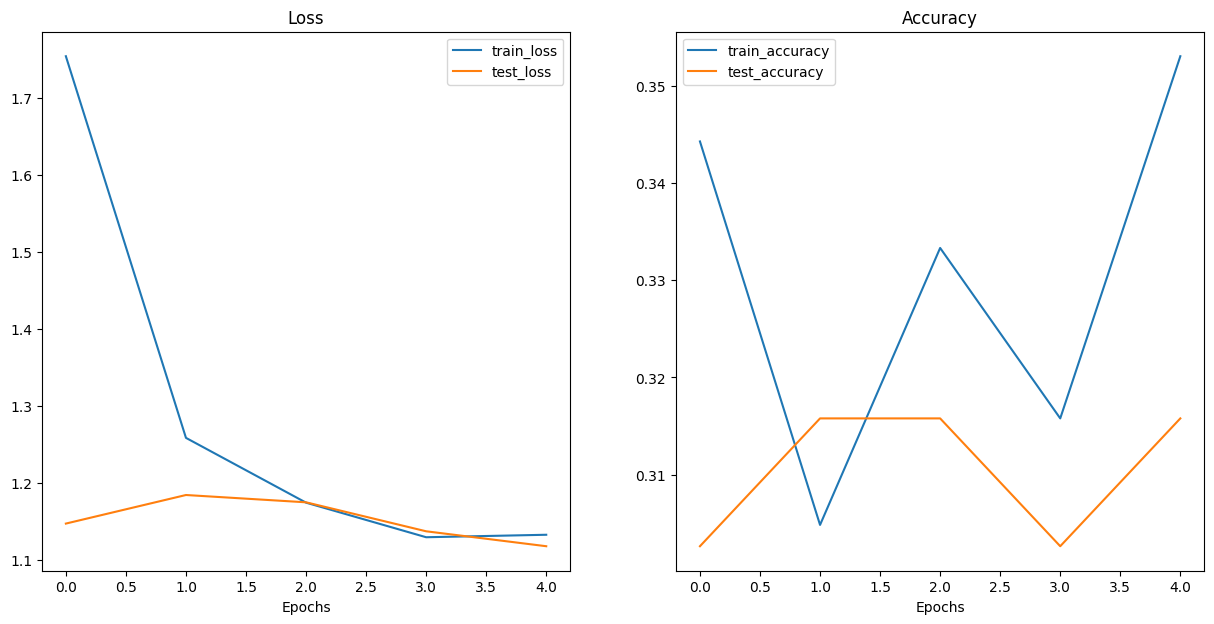

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update custom head layer
pretrained_vit.heads = nn.Linear(in_features=768, out_features=3).to(device)

In [ ]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 3]                    768                       Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          (590,592)                 False
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             151,296                   False
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             (7,087,872)   

### 10.3 Preparing data for the pretrained ViT model



In [ ]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
print(vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
import os
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        transform=vit_transforms,
                                                                                        batch_size=batch_size,
                                                                                        num_workers=os.cpu_count())

In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)

In [ ]:
results_pretrained = engine.train(model=pretrained_vit,
                                  train_dataloader=train_dataloader_pretrained,
                                  test_dataloader=test_dataloader_pretrained,
                                  optimizer=optimizer,
                                  loss_fn = loss_fn,
                                  epochs=5,
                                  device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2327 | train_acc: 0.9156 | test_loss: 0.0677 | test_acc: 0.9800
Epoch: 2 | train_loss: 0.0680 | train_acc: 0.9844 | test_loss: 0.0736 | test_acc: 0.9800
Epoch: 3 | train_loss: 0.0262 | train_acc: 0.9978 | test_loss: 0.0562 | test_acc: 0.9733
Epoch: 4 | train_loss: 0.0142 | train_acc: 1.0000 | test_loss: 0.0530 | test_acc: 0.9733
Epoch: 5 | train_loss: 0.0094 | train_acc: 1.0000 | test_loss: 0.0493 | test_acc: 0.9800


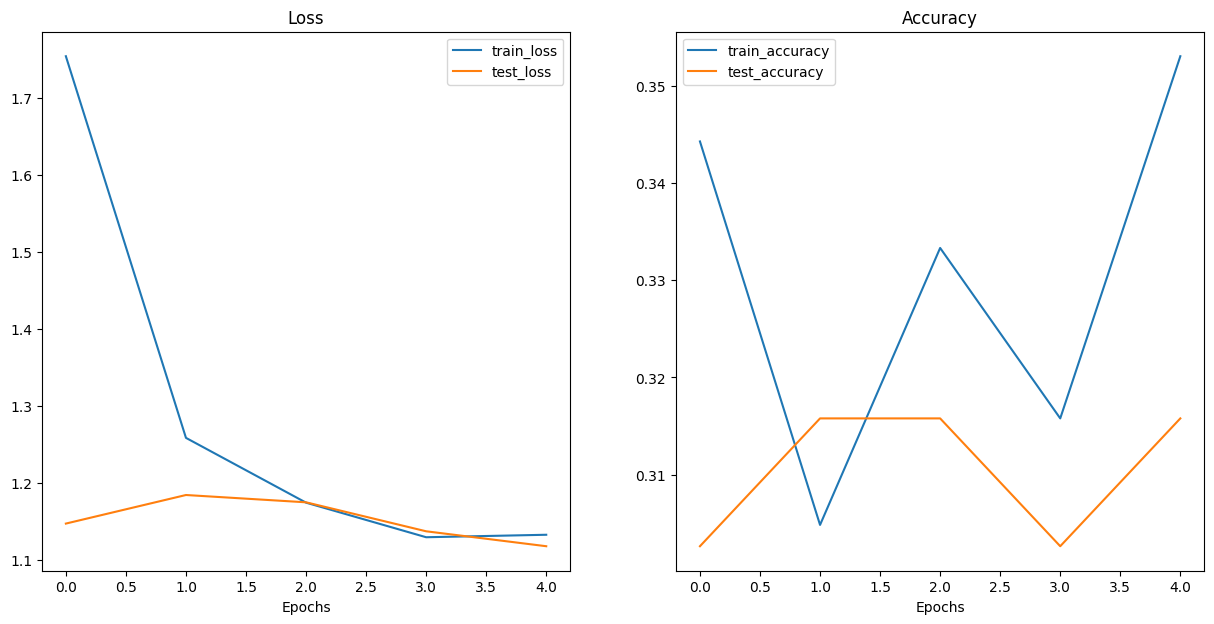

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### 10.6 Save our best performing ViT model

In [ ]:
torch.save(pretrained_vit, f='pretrained_vit.pth')

In [ ]:
# Get model size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_size = Path('pretrained_vit.pth').stat().st_size // 1024**2
pretrained_vit_size

## 11. Predicting custom image

In [ ]:
import requests
from going_modular.predictions import pred_and_plot_image

custom_image_path = Path('data') / '08-pizza.png'
if not custom_image_path.is_file():
  response = requests.get('')
  with open(custom_image_path, 'wb') as f:
    f.write(response.content)

pred_and_plot_image(model=pretrained_vit,
                    class_names=class_names,
                    image_path = custom_image_path)